In [6]:
# Imports 
%matplotlib inline
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import *
from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot
import numpy as np
from math import cos, pi
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9) # set default size for all figures

In [253]:
beta=1
n_iw=1024
w_ph=0.1
U=0.1
half_bandwidth=2
lambda_0=2*U/w_ph/half_bandwidth

In [254]:
lambda_0

1.0

In [255]:
%reload_ext cpp2py.magic

In [256]:
%%cpp2py -C pytriqs
#include <triqs/gfs.hpp>
using namespace triqs::gfs;
        
gf_view<imfreq, scalar_valued> bubble(gf_view<imfreq, scalar_valued> g0) {
    auto gt = make_gf_from_fourier<0>(g0);
    auto mt = gt.mesh();
    double beta = mt.domain().beta;
    auto mtb = gf_mesh<imtime>{beta, Boson, mt.size()};
    auto chi0 = gf_view<imtime, scalar_valued>{mtb};
    for (auto const&t : mtb) 
        chi0[t] = 2*gt(beta - t) * gt(t); 
    return make_gf_from_fourier<0>(chi0);
}

gf_view<imfreq, scalar_valued>  ME_sigma(gf_view<imfreq, scalar_valued>  g, 
                                         gf_view<imfreq, scalar_valued>  d) {
    auto gt = make_gf_from_fourier<0>(g);
    auto dt = make_gf_from_fourier<0>(d);
    auto mt = gt.mesh();
    double beta = mt.domain().beta;
    auto sigma = gf_view<imtime, scalar_valued> {mt};
    for (auto const &t : mt) 
        sigma[t] = -gt(beta - t) * dt(t); 
    return make_gf_from_fourier<0>(sigma);
}

In [257]:
g0=GfImFreq(name=r'$G_0$', beta=beta, statistic='Fermion', n_points=n_iw, target_shape=[])
g=GfImFreq(name=r'$G$', beta=beta, statistic='Fermion', n_points=n_iw, target_shape=[])
sigma=GfImFreq(name=r'$\Sigma$', beta=beta, statistic='Fermion', n_points=n_iw, target_shape=[])

d0=GfImFreq(name=r'$D_0$', beta=beta, statistic='Boson', n_points=n_iw, target_shape=[])
d=GfImFreq(name=r'$D$', beta=beta, statistic='Boson', n_points=n_iw, target_shape=[])
p0=GfImFreq(name=r'$P_0$', beta=beta, statistic='Boson', n_points=n_iw, target_shape=[])

In [258]:
g0 << SemiCircular(half_bandwidth)
g << SemiCircular(half_bandwidth)
for iwm in d0.mesh:d0[iwm] = 2.0*w_ph / (iwm.value**2-w_ph**2)
n_iter=10
for i in range(n_iter):
    d<<inverse(inverse(d0)-U*bubble(g))
    g<<inverse(inverse(g0)-U*ME_sigma(g,d))

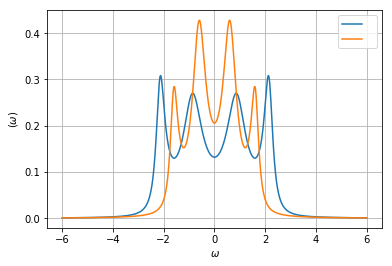

In [259]:
greal0 = GfReFreq(target_shape=[], window = (-6.0,6.0), n_points = 601)
greal = GfReFreq(target_shape=[], window = (-6.0,6.0), n_points = 601)
greal.set_from_pade(g,freq_offset = 0.1)
greal0.set_from_pade(g0,freq_offset = 0.1)
oplot(greal,mode='S')
oplot(greal0,mode='S')
plt.grid()
# plt.xlim([0,1])

(0, 1)

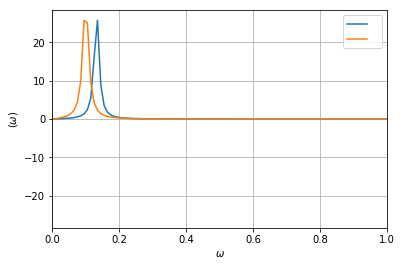

In [260]:
greal0 = GfReFreq(target_shape=[], window = (-3.0,3.0), n_points = 600)
greal = GfReFreq(target_shape=[], window = (-3.0,3.0), n_points = 600)
greal.set_from_pade(d,freq_offset = 0.01)
greal0.set_from_pade(d0,freq_offset = 0.01)
oplot(greal,mode='S')
oplot(greal0,mode='S')
plt.grid()
plt.xlim([0,1])
# plt.ylim([0,None])

In [261]:
g0_tau = GfImTime(target_shape=[], beta = beta)
g_tau = GfImTime(target_shape=[], beta = beta)

In [262]:
g0_tau.set_from_fourier(g0)
g_tau.set_from_fourier(g)

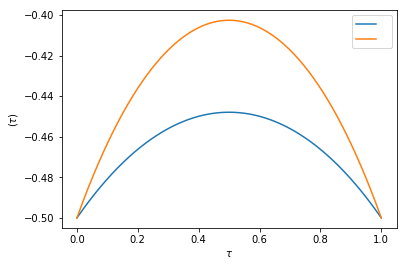

In [263]:
oplot(g0_tau.real)
oplot(g_tau.real)